In [ ]:
# Mount Google Drive (run this cell first in Colab)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Ridge
from numpy.linalg import LinAlgError

# --------------------------
# 1. Load and Prepare Dataset
# --------------------------
file_path = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 35.xlsx"
df = pd.read_excel(file_path)

# Check for required columns in Final 35
required_columns = ["Return_Next 3M", "Timestamp", "PERMNO"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing in the Final 35 database.")

# Drop rows where the target is missing
df = df.dropna(subset=["Return_Next 3M"]).reset_index(drop=True)

# Ensure Timestamp is integer (if it isn’t already)
df["Timestamp"] = df["Timestamp"].astype(int)

# --------------------------
# 2. Define Model Parameters and Variables
# --------------------------
rolling_window = 36  # Define a 36-month rolling window
y_var = "Return_Next 3M"

# Assumption: The first few columns (e.g. PERMNO, Timestamp, etc.) are non-feature data.
# Adjust the slice below if the ordering in Final 35 is different.
x_vars = df.columns[3:]

# Storage for predictions
rolling_predictions = []

# Unique sorted timestamps
timestamps = sorted(df["Timestamp"].unique())

# --------------------------
# 3. Rolling Window Model Loop
# --------------------------
for i in range(len(timestamps) - rolling_window - 5):
    # Define training, validation, and test periods based on timestamps
    train_start = timestamps[i]
    train_end = timestamps[i + rolling_window - 1]

    # Check to ensure that the test period does not go beyond the dataset
    if (i + rolling_window + 5) >= len(timestamps):
        break

    # Define test and validation period boundaries
    test_start = timestamps[i + rolling_window + 3]
    test_end = timestamps[i + rolling_window + 5]
    validation_start = timestamps[i + rolling_window]
    validation_end = timestamps[i + rolling_window + 2]

    # Select data for each period
    train_data = df[(df["Timestamp"] >= train_start) & (df["Timestamp"] <= train_end)]
    test_data = df[(df["Timestamp"] >= test_start) & (df["Timestamp"] <= test_end)]
    validation_data = df[(df["Timestamp"] >= validation_start) & (df["Timestamp"] <= validation_end)]

    print(f"🟢 Processing Timestamp {train_end} | Train: {len(train_data)}, Test: {len(test_data)}, Validation: {len(validation_data)}")

    # Skip if there isn’t enough data in any period
    if len(train_data) < rolling_window or len(test_data) == 0 or len(validation_data) == 0:
        print(f"⚠️ Skipping Timestamp {train_end} due to insufficient data")
        continue

    # Prepare X and Y matrices for training and validation
    X_train = train_data[x_vars]
    y_train = train_data[y_var]
    X_validation = validation_data[x_vars]

    # Check for NaNs or constant target variable
    if X_train.isnull().values.any() or y_train.isnull().values.any():
        print(f"⚠️ Skipping Timestamp {train_end} due to NaN values in dataset")
        continue

    if y_train.nunique() == 1:
        print(f"⚠️ Skipping Timestamp {train_end} due to constant target variable")
        continue

    # --------------------------
    # 4. Model Estimation
    # --------------------------
    # Check condition number for multicollinearity
    condition_number = np.linalg.cond(sm.add_constant(X_train))
    print(f"📊 Condition Number: {condition_number:.2f}")

    if condition_number > 1000:
        # High multicollinearity: use Ridge Regression as fallback
        print(f"⚠️ High multicollinearity detected at {train_end}, switching to Ridge Regression")
        ridge_model = Ridge(alpha=1.0)
        ridge_model.fit(X_train, y_train)
        intercept = ridge_model.intercept_
        latest_coefficients = ridge_model.coef_
    else:
        try:
            # Fit RollingOLS on training data (with constant added)
            rolling_model = RollingOLS(y_train, sm.add_constant(X_train), window=rolling_window).fit()
            # Extract the latest parameters: first element is the intercept, rest are coefficients
            params = rolling_model.params.iloc[-1].values
            intercept = params[0]
            latest_coefficients = params[1:]
        except LinAlgError:
            print(f"⚠️ Singular matrix error at {train_end}, switching to Ridge Regression")
            ridge_model = Ridge(alpha=1.0)
            ridge_model.fit(X_train, y_train)
            intercept = ridge_model.intercept_
            latest_coefficients = ridge_model.coef_

    # Check that the number of coefficients matches the features in validation data
    if X_validation.shape[1] != len(latest_coefficients):
        print(f"⚠️ Shape Mismatch at {train_end}. Expected {X_validation.shape[1]}, got {len(latest_coefficients)}")
        continue

    # --------------------------
    # 5. Compute and Store Predictions
    # --------------------------
    validation_predictions = np.dot(X_validation, latest_coefficients) + intercept

    validation_data = validation_data.copy()
    validation_data["Predicted_Return_Next_3M"] = validation_predictions
    rolling_predictions.append(validation_data)

    # Debug: print sample predictions
    print(validation_data[["Timestamp", "Predicted_Return_Next_3M"]].head())

# --------------------------
# 6. Finalize Results and Output
# --------------------------
if len(rolling_predictions) == 0:
    raise ValueError("🚨 No valid predictions were generated. Check the loop conditions!")

final_predictions = pd.concat(rolling_predictions, ignore_index=True)

# Compare top-performing stocks based on actual vs. predicted returns
top_1_actual = final_predictions.nlargest(1, y_var)
top_1_predicted = final_predictions.nlargest(1, "Predicted_Return_Next_3M")

print("📊 **Actual Top 1 Stock (Based on Real Returns)**")
print(top_1_actual[["Timestamp", "PERMNO", y_var]])

print("\n📈 **Predicted Top 1 Stock (Based on Model Forecast)**")
print(top_1_predicted[["Timestamp", "PERMNO", "Predicted_Return_Next_3M"]])

# Save the final predictions to an Excel file named Final 47
output_file = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 47.xlsx"
final_predictions.to_excel(output_file, index=False)
print(f"✅ Moving Window Regression Completed! Results saved as: {output_file}")


Mounted at /content/drive
🟢 Processing Timestamp 200512 | Train: 14986, Test: 1293, Validation: 1272
📊 Condition Number: 17335492116918241280.00
⚠️ High multicollinearity detected at 200512, switching to Ridge Regression
     Timestamp  Predicted_Return_Next_3M
36      200601                  0.053625
37      200602                  0.054545
38      200603                  0.056378
285     200601                  0.082891
286     200602                  0.083938
🟢 Processing Timestamp 200601 | Train: 14997, Test: 1294, Validation: 1282
📊 Condition Number: 9168640883563593728.00
⚠️ High multicollinearity detected at 200601, switching to Ridge Regression
     Timestamp  Predicted_Return_Next_3M
37      200602                  0.054985
38      200603                  0.056662
39      200604                  0.058802
286     200602                  0.081025
287     200603                  0.081731
🟢 Processing Timestamp 200602 | Train: 15007, Test: 1296, Validation: 1289
📊 Condition Number

In [ ]:
# Mount Google Drive (run this cell first in Colab)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from numpy.linalg import LinAlgError

# --------------------------
# 1. Load and Prepare Dataset
# --------------------------
file_path = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 35.xlsx"
df = pd.read_excel(file_path)

# Check for required columns
required_columns = ["Return_Next 3M", "Timestamp", "PERMNO"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing in the Final 35 database.")

# Drop rows with missing target values and convert Timestamp to integer.
df = df.dropna(subset=["Return_Next 3M"]).reset_index(drop=True)
df["Timestamp"] = df["Timestamp"].astype(int)

# Define target variable and feature columns.
y_var = "Return_Next 3M"
# Assume that the first few columns (e.g., PERMNO, Timestamp) are not features.
x_vars = df.columns[3:]

# --------------------------
# 2. Define Training Window for Prediction
# --------------------------
# We want to predict for timestamp 202312.
target_timestamp = 202312
# Use all data before 202312 as historical training data.
train_data = df[df["Timestamp"] < target_timestamp].copy()

# Get sorted unique timestamps from training data.
unique_train_ts = sorted(train_data["Timestamp"].unique())
if len(unique_train_ts) < 36:
    raise ValueError("Not enough historical data to form a 36-month training window.")

# Select the last 36 unique timestamps as the training window.
train_window_ts = unique_train_ts[-36:]
train_window = train_data[train_data["Timestamp"].isin(train_window_ts)]

X_train = train_window[x_vars]
y_train = train_window[y_var]

# --------------------------
# 3. Model Estimation on the Training Window
# --------------------------
# Add constant to X_train.
X_train_const = sm.add_constant(X_train)
# Compute condition number.
cond_number = np.linalg.cond(X_train_const)
print(f"Training window condition number: {cond_number:.2f}")

# If multicollinearity is high, use Ridge; otherwise, use OLS.
if cond_number > 1000:
    print("High multicollinearity detected; using Ridge Regression.")
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    intercept_new = ridge_model.intercept_
    coefficients_new = ridge_model.coef_
else:
    try:
        model = sm.OLS(y_train, X_train_const).fit()
        params = model.params.values  # first element is the intercept
        intercept_new = params[0]
        coefficients_new = params[1:]
    except LinAlgError:
        print("Singular matrix encountered. Switching to Ridge Regression.")
        ridge_model = Ridge(alpha=1.0)
        ridge_model.fit(X_train, y_train)
        intercept_new = ridge_model.intercept_
        coefficients_new = ridge_model.coef_

# --------------------------
# 4. Get Data for Timestamp 202312
# --------------------------
new_data = df[df["Timestamp"] == target_timestamp]
if new_data.empty:
    raise ValueError("No data available for timestamp 202312.")

X_new = new_data[x_vars]

# --------------------------
# 5. Compute the Prediction
# --------------------------
# For a linear model, prediction is: intercept + X_new.dot(coefficients)
prediction = np.dot(X_new, coefficients_new) + intercept_new

# Add the prediction as a new column.
new_data = new_data.copy()
new_data["Predicted_Return_Next_3M"] = prediction

print("Prediction for timestamp", target_timestamp, ":")
print(new_data[["Timestamp", "PERMNO", "Predicted_Return_Next_3M"]])

# --------------------------
# 6. Save the Output
# --------------------------
output_file = "/content/drive/My Drive/Colab Notebooks/823 Project/Portfolio_Model 2.xlsx"
new_data.to_excel(output_file, index=False)
print(f"✅ Predictions saved as: {output_file}")


Mounted at /content/drive
Training window condition number: 20052706089531580416.00
High multicollinearity detected; using Ridge Regression.
Prediction for timestamp 202312 :
       Timestamp  PERMNO  Predicted_Return_Next_3M
31353     202312   29938                  0.001487
✅ Predictions saved as: /content/drive/My Drive/Colab Notebooks/823 Project/Portfolio_Model 2.xlsx


In [ ]:
import statsmodels.api as sm

# Identify the indices for the last rolling window.
# We assume that predictions_valid (and y_train) have been computed as in the diagnostic code.
last_window_index = predictions_valid.tail(rolling_window).index

# Extract the data for the last window.
X_last = X_train.loc[last_window_index]
y_last = y_train.loc[last_window_index]

# Add a constant term to the predictors.
X_last_const = sm.add_constant(X_last)

# Fit a standard OLS on the last window of data.
ols_last = sm.OLS(y_last, X_last_const).fit()

# Print the summary of the OLS results.
print(ols_last.summary())


                            OLS Regression Results                            
Dep. Variable:         Return_Next 3M   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     1.857
Date:                Wed, 12 Feb 2025   Prob (F-statistic):             0.0978
Time:                        10:34:24   Log-Likelihood:                 51.478
No. Observations:                  36   AIC:                            -76.96
Df Residuals:                      23   BIC:                            -56.37
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
PS            

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [ ]:
# Mount Google Drive (run this cell first in Colab)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from numpy.linalg import LinAlgError

# --------------------------
# 1. Load and Prepare Dataset
# --------------------------
file_path = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 35.xlsx"
df = pd.read_excel(file_path)

# Ensure required columns are present
required_columns = ["Return_Next 3M", "Timestamp", "PERMNO"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing in the Final 35 database.")

# Drop rows with missing target and ensure Timestamp is integer.
df = df.dropna(subset=["Return_Next 3M"]).reset_index(drop=True)
df["Timestamp"] = df["Timestamp"].astype(int)

# Define target variable and feature columns.
y_var = "Return_Next 3M"
# Assume that columns before index 3 (e.g., PERMNO, Timestamp, etc.) are identifiers.
x_vars = df.columns[3:]

# --------------------------
# 2. Define Training Window for Prediction
# --------------------------
# We wish to predict for timestamp 202312.
target_timestamp = 202312

# Use all historical data before target_timestamp.
train_data = df[df["Timestamp"] < target_timestamp].copy()

# Get sorted unique timestamps from training data.
unique_train_ts = sorted(train_data["Timestamp"].unique())
if len(unique_train_ts) < 36:
    raise ValueError("Not enough historical data to form a 36-month training window.")

# Select the last 36 unique timestamps as the training window.
train_window_ts = unique_train_ts[-36:]
train_window = train_data[train_data["Timestamp"].isin(train_window_ts)]

X_train = train_window[x_vars]
y_train = train_window[y_var]

# --------------------------
# 3. Model Estimation on the Training Window
# --------------------------
# Add constant term.
X_train_const = sm.add_constant(X_train)
cond_number = np.linalg.cond(X_train_const)
print(f"Training window condition number: {cond_number:.2f}")

# If multicollinearity is high, use Ridge Regression; otherwise, use OLS.
if cond_number > 1000:
    print("High multicollinearity detected; using Ridge Regression.")
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    intercept_new = ridge_model.intercept_
    coefficients_new = ridge_model.coef_
else:
    try:
        model = sm.OLS(y_train, X_train_const).fit()
        params = model.params.values  # first element is the intercept
        intercept_new = params[0]
        coefficients_new = params[1:]
    except LinAlgError:
        print("Singular matrix encountered. Switching to Ridge Regression.")
        ridge_model = Ridge(alpha=1.0)
        ridge_model.fit(X_train, y_train)
        intercept_new = ridge_model.intercept_
        coefficients_new = ridge_model.coef_

# --------------------------
# 4. Get Data for Timestamp 202312 and Predict for All PERMNO
# --------------------------
# Select all rows with Timestamp equal to target_timestamp.
new_data = df[df["Timestamp"] == target_timestamp]
if new_data.empty:
    raise ValueError("No data available for timestamp 202312.")

# Prepare to compute predictions for each PERMNO.
# (Even though the model is global, grouping by PERMNO ensures that if multiple rows exist for different stocks, each gets a prediction.)
predictions_list = []
for permno, group in new_data.groupby("PERMNO"):
    X_new = group[x_vars]
    # Compute prediction: intercept + dot-product of features and coefficients.
    pred = np.dot(X_new, coefficients_new) + intercept_new
    group = group.copy()
    group["Predicted_Return_Next_3M"] = pred
    predictions_list.append(group)

# Concatenate all predictions.
all_predictions = pd.concat(predictions_list, ignore_index=True)

print("Predictions for timestamp", target_timestamp, "for all PERMNO:")
print(all_predictions[["Timestamp", "PERMNO", "Predicted_Return_Next_3M"]])

# --------------------------
# 5. Save the Output
# --------------------------
output_file = "/content/drive/My Drive/Colab Notebooks/823 Project/Portfolio_Model 2.xlsx"
all_predictions.to_excel(output_file, index=False)
print(f"✅ Predictions saved as: {output_file}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training window condition number: 20052706089531580416.00
High multicollinearity detected; using Ridge Regression.
Predictions for timestamp 202312 for all PERMNO:
   Timestamp  PERMNO  Predicted_Return_Next_3M
0     202312   29938                  0.001487
✅ Predictions saved as: /content/drive/My Drive/Colab Notebooks/823 Project/Portfolio_Model 2.xlsx


🟢 Processed window ending at 200512 | Avg R-Squared: -866116864514279680.0000
🟢 Processed window ending at 200601 | Avg R-Squared: -134229734159677620224.0000
🟢 Processed window ending at 200602 | Avg R-Squared: -2589537079593038336.0000
🟢 Processed window ending at 200603 | Avg R-Squared: -36570830918968176640.0000
🟢 Processed window ending at 200604 | Avg R-Squared: -9065937355226728448.0000
🟢 Processed window ending at 200605 | Avg R-Squared: -83752098245201461248.0000
🟢 Processed window ending at 200606 | Avg R-Squared: -1189704826428947456.0000
🟢 Processed window ending at 200607 | Avg R-Squared: -215868124122195744.0000
🟢 Processed window ending at 200608 | Avg R-Squared: -14741322797836392448.0000
🟢 Processed window ending at 200609 | Avg R-Squared: -2729501669578438144.0000
🟢 Processed window ending at 200610 | Avg R-Squared: -5143443293110902784.0000
🟢 Processed window ending at 200611 | Avg R-Squared: -33977395706751217664.0000
🟢 Processed window ending at 200612 | Avg R-Squa

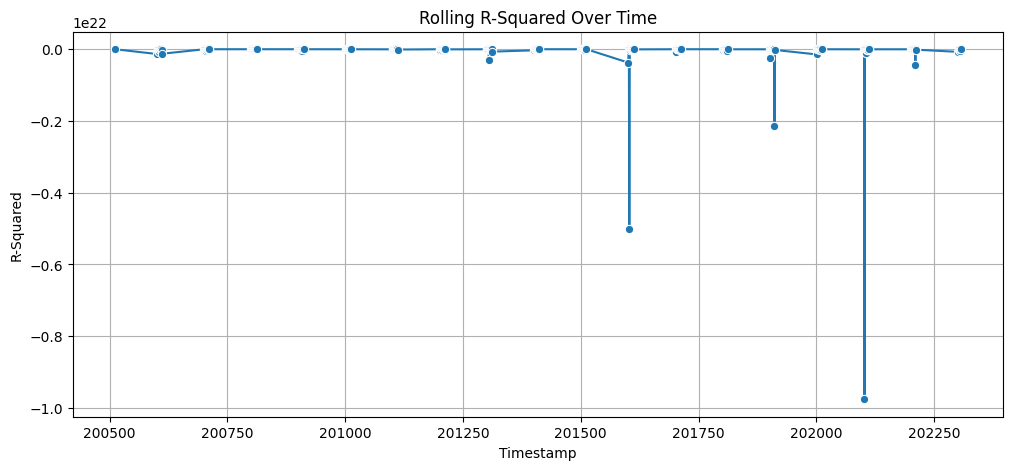

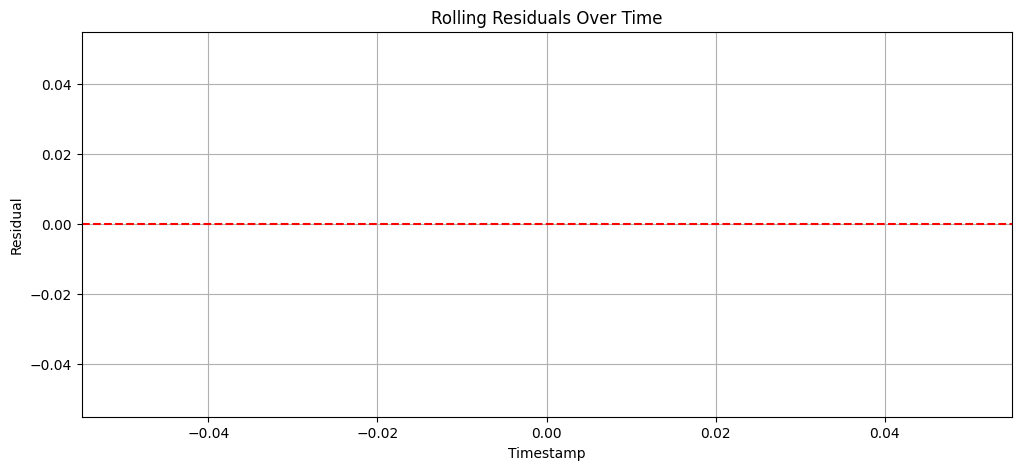

✅ RollingOLS Diagnostics Saved Successfully!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# ===== Step 1: Load and Prepare Data =====
file_path = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 35.xlsx"
df = pd.read_excel(file_path)

# Check for required columns
required_columns = ["Return_Next 3M", "Timestamp", "PERMNO"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing in the dataset.")

# Drop rows with missing target and ensure Timestamp is an integer
df = df.dropna(subset=["Return_Next 3M"]).reset_index(drop=True)
df["Timestamp"] = df["Timestamp"].astype(int)

# Define target and feature columns.
y_var = "Return_Next 3M"
# Assume first three columns (e.g., PERMNO, Timestamp, and possibly one more) are identifiers.
x_vars = df.columns[3:]

# ===== Step 2: Define Rolling Window Parameters =====
# Create a sorted list of unique timestamps.
timestamps = sorted(df["Timestamp"].unique())
rolling_window = 36  # Define the length of each rolling window

# Initialize storage for diagnostics.
rolling_coefficients = []  # List to store coefficient vectors for each window.
r_squared_values = []      # List to store the mean R-squared for each window.
timestamps_recorded = []   # Timestamps corresponding to each window (here, we record the window-end timestamp).
residuals_values = []      # List to store residuals from validation.
residuals_timestamps = []  # List to store the timestamp corresponding to each residual.

# ===== Step 3: RollingOLS Loop to Collect Diagnostics =====
# For each valid window, use the training window then use the next timestamp as validation.
for i in range(len(timestamps) - rolling_window - 5):
    train_start = timestamps[i]
    train_end = timestamps[i + rolling_window - 1]

    # Ensure that the validation period (here, the next timestamp) exists.
    validation_ts = timestamps[i + rolling_window]
    if (i + rolling_window + 5) >= len(timestamps):
        break

    # Select training data between train_start and train_end.
    train_data = df[(df["Timestamp"] >= train_start) & (df["Timestamp"] <= train_end)]
    # Select validation data exactly for the next timestamp.
    validation_data = df[df["Timestamp"] == validation_ts]

    # If there is not enough data, skip this window.
    if len(train_data) < rolling_window or validation_data.empty:
        continue

    # Prepare X and Y for training. Add constant.
    X_train = sm.add_constant(train_data[x_vars], has_constant="add")
    y_train = train_data[y_var]

    # Prepare validation data predictors.
    X_validation = sm.add_constant(validation_data[x_vars], has_constant="add")

    # ===== Run RollingOLS on the Training Window =====
    rolling_model = RollingOLS(y_train, X_train, window=rolling_window).fit()

    # Store the coefficients from the last step of the rolling window.
    latest_coefficients = rolling_model.params.iloc[-1].values
    rolling_coefficients.append(latest_coefficients)
    timestamps_recorded.append(train_end)

    # Compute an average R-squared over the window.
    # (Note: RollingOLS does not directly compute a single R-squared value, so we use the mean of rsquared across the window.)
    avg_r_squared = rolling_model.rsquared.mean()
    r_squared_values.append(avg_r_squared)

    # ===== Compute Predictions and Residuals on Validation Data =====
    # Manual prediction using: fitted = X_validation.dot(coefficients)
    fitted_values = np.dot(X_validation, latest_coefficients)
    actual_values = validation_data[y_var].values

    if len(actual_values) == len(fitted_values):
        residuals = actual_values - fitted_values
        for r in residuals:
            residuals_values.append(r)
            residuals_timestamps.append(validation_ts)
    else:
        for _ in range(len(actual_values)):
            residuals_values.append(np.nan)
            residuals_timestamps.append(validation_ts)

    print(f"🟢 Processed window ending at {train_end} | Avg R-Squared: {avg_r_squared:.4f}")

# ===== Step 4: Convert Diagnostics to DataFrames =====
coefficients_df = pd.DataFrame(
    rolling_coefficients,
    columns=["Intercept"] + list(x_vars),
    index=timestamps_recorded
)
r_squared_df = pd.DataFrame({
    "Timestamp": timestamps_recorded,
    "R-Squared": r_squared_values
})
residuals_df = pd.DataFrame({
    "Timestamp": residuals_timestamps,
    "Residual": residuals_values
})

# ===== Step 5: Plot Diagnostics =====
# Plot Rolling R-Squared Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(x="Timestamp", y="R-Squared", data=r_squared_df, marker="o")
plt.title("Rolling R-Squared Over Time")
plt.xlabel("Timestamp")
plt.ylabel("R-Squared")
plt.grid(True)
plt.show()

# Plot Residuals Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(x="Timestamp", y="Residual", data=residuals_df, marker="o")
plt.title("Rolling Residuals Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Residual")
plt.axhline(0, color="red", linestyle="--")
plt.grid(True)
plt.show()

# ===== Step 6: Save Diagnostics to CSV =====
coefficients_df.to_csv("/content/drive/My Drive/Colab Notebooks/823 Project/RollingOLS_Coefficients.csv")
r_squared_df.to_csv("/content/drive/My Drive/Colab Notebooks/823 Project/RollingOLS_RSquared.csv")
residuals_df.to_csv("/content/drive/My Drive/Colab Notebooks/823 Project/RollingOLS_Residuals.csv")

print("✅ RollingOLS Diagnostics Saved Successfully!")


Mounted at /content/drive
Processed window ending at 200512 | Avg R²: -866116864514279680.0000 | Adjusted R²: -2165292161285699072.0000
Processed window ending at 200601 | Avg R²: -134229734159677620224.0000 | Adjusted R²: -335574335399194066944.0000
Processed window ending at 200602 | Avg R²: -2589537079593038336.0000 | Adjusted R²: -6473842698982595584.0000
Processed window ending at 200603 | Avg R²: -36570830918968176640.0000 | Adjusted R²: -91427077297420435456.0000
Processed window ending at 200604 | Avg R²: -9065937355226728448.0000 | Adjusted R²: -22664843388066820096.0000
Processed window ending at 200605 | Avg R²: -83752098245201461248.0000 | Adjusted R²: -209380245613003669504.0000
Processed window ending at 200606 | Avg R²: -1189704826428947456.0000 | Adjusted R²: -2974262066072368640.0000
Processed window ending at 200607 | Avg R²: -215868124122195744.0000 | Adjusted R²: -539670310305489344.0000
Processed window ending at 200608 | Avg R²: -14741322797836392448.0000 | Adjust

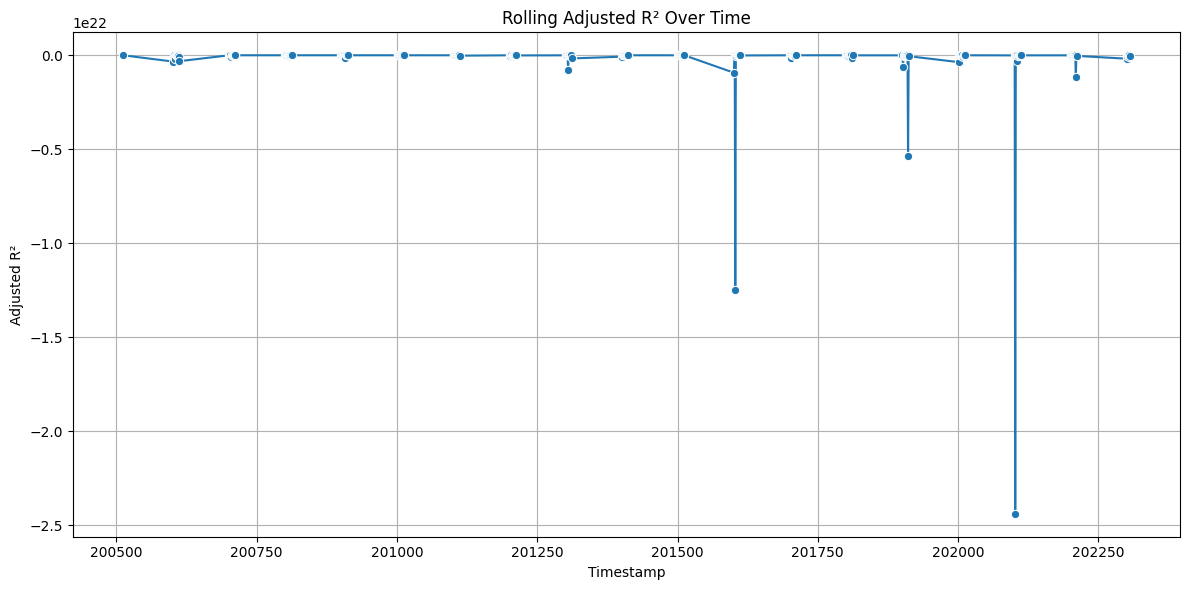

✅ Adjusted R² plot and data saved successfully!


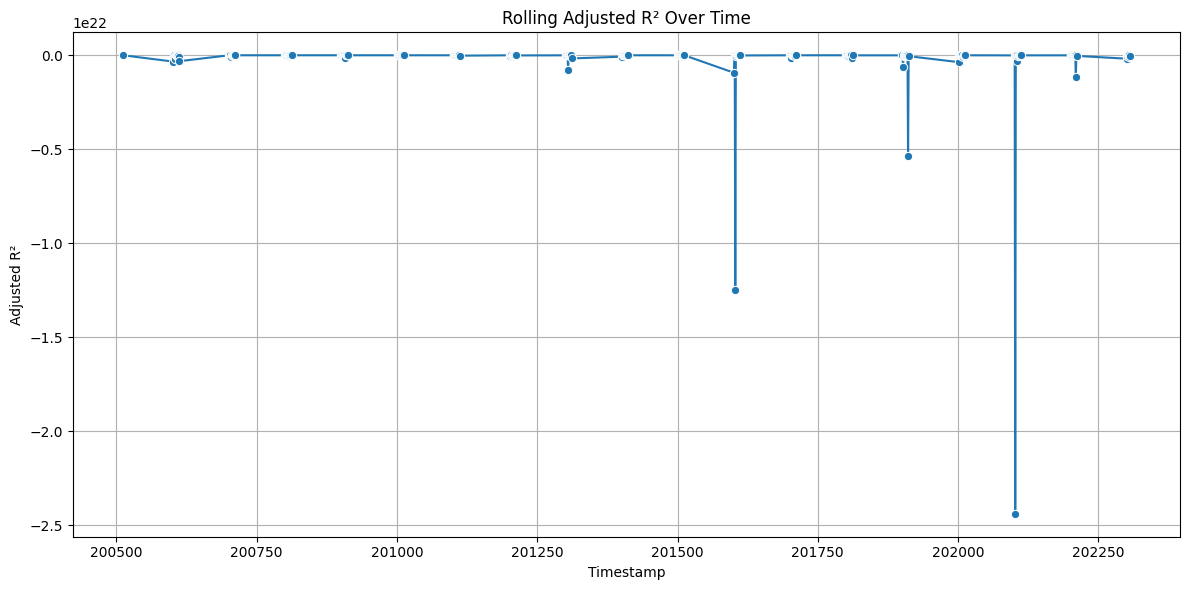

In [1]:
# Mount Google Drive (run this cell first in Colab)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# ===== Step 1: Load and Prepare Data =====
file_path = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 35.xlsx"
df = pd.read_excel(file_path)

# Check for required columns and drop missing targets
required_columns = ["Return_Next 3M", "Timestamp", "PERMNO"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' is missing in the dataset.")

df = df.dropna(subset=["Return_Next 3M"]).reset_index(drop=True)
df["Timestamp"] = df["Timestamp"].astype(int)

y_var = "Return_Next 3M"
# Assume that the first few columns are identifiers; features start at index 3.
x_vars = df.columns[3:]

# ===== Step 2: Define Rolling Window Parameters =====
rolling_window = 36  # window length in months
timestamps = sorted(df["Timestamp"].unique())

# Initialize storage for Adjusted R² diagnostics.
adj_r_squared_values = []
timestamps_recorded = []

# Determine number of predictors (without constant).
p = len(x_vars)
n = rolling_window  # number of observations in each window

# ===== Step 3: RollingOLS Loop and Adjusted R² Calculation =====
for i in range(len(timestamps) - rolling_window - 5):
    train_start = timestamps[i]
    train_end = timestamps[i + rolling_window - 1]
    # Use the next timestamp as validation (though here we use the rolling model's R²)
    validation_ts = timestamps[i + rolling_window]

    # Select training data for the window.
    train_data = df[(df["Timestamp"] >= train_start) & (df["Timestamp"] <= train_end)]
    # Check if training data is sufficient.
    if len(train_data) < rolling_window:
        continue

    # Prepare predictors and target. Add constant.
    X_train = sm.add_constant(train_data[x_vars], has_constant="add")
    y_train = train_data[y_var]

    # Run RollingOLS on the training window.
    rolling_model = RollingOLS(y_train, X_train, window=rolling_window).fit()

    # Get the average R² over the window.
    avg_r_squared = rolling_model.rsquared.mean()
    # Compute Adjusted R² using the formula:
    # Adjusted R² = 1 - (1-R²) * ((n-1)/(n-p-1))
    adj_R2 = 1 - (1 - avg_r_squared) * ((n - 1) / (n - p - 1))

    adj_r_squared_values.append(adj_R2)
    timestamps_recorded.append(train_end)

    print(f"Processed window ending at {train_end} | Avg R²: {avg_r_squared:.4f} | Adjusted R²: {adj_R2:.4f}")

# ===== Step 4: Plot Adjusted R² Over Time =====
adj_r2_df = pd.DataFrame({
    "Timestamp": timestamps_recorded,
    "Adjusted_R2": adj_r_squared_values
})

plt.figure(figsize=(12, 6))
sns.lineplot(x="Timestamp", y="Adjusted_R2", data=adj_r2_df, marker="o")
plt.title("Rolling Adjusted R² Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Adjusted R²")
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== Step 5: Save the Plot and Data =====
# Save the DataFrame as CSV.
adj_r2_df.to_csv("/content/drive/My Drive/Colab Notebooks/823 Project/RollingOLS_Adjusted_R2.csv", index=False)

# Save the plot to Google Drive.
plt.figure(figsize=(12, 6))
sns.lineplot(x="Timestamp", y="Adjusted_R2", data=adj_r2_df, marker="o")
plt.title("Rolling Adjusted R² Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Adjusted R²")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Colab Notebooks/823 Project/RollingOLS_Adjusted_R2.png")
print("✅ Adjusted R² plot and data saved successfully!")


In [2]:
# Mount Google Drive (if needed for saving outputs)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# For SHAP
import shap

# For LIME
from lime.lime_tabular import LimeTabularExplainer

# For PDPs: using PDPbox (alternatively, you can use sklearn.inspection)
from pdpbox import pdp, info_plots

# =============================================================================
# Example: Suppose you have already built a model.
# For demonstration, we fit a simple Ridge model on training data.
# =============================================================================

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# Load sample data (or use your own)
# For example, use part of the Final 35 dataset:
file_path = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 35.xlsx"
df = pd.read_excel(file_path)
df = df.dropna(subset=["Return_Next 3M"]).reset_index(drop=True)
df["Timestamp"] = df["Timestamp"].astype(int)
y = df["Return_Next 3M"]
# Assume features are all columns from index 3 onward.
X = df[df.columns[3:]]

# Split data for demonstration (train-test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# =============================================================================
# 1. SHAP (Shapley Values) Analysis
# =============================================================================
# For a linear model, we can use the LinearExplainer (or KernelExplainer if needed).
explainer = shap.LinearExplainer(ridge_model, X_train, feature_perturbation="interventional")
# Compute SHAP values on a sample from the test set.
shap_values = explainer.shap_values(X_test)

# Summary plot: shows global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary (Bar) for Ridge Model")
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Colab Notebooks/823 Project/SHAP_Summary_Bar.png")
plt.show()

# Detailed summary (beeswarm) plot
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary (Beeswarm) for Ridge Model")
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Colab Notebooks/823 Project/SHAP_Summary_Beeswarm.png")
plt.show()

# =============================================================================
# 2. LIME Analysis
# =============================================================================
# Create a LimeTabularExplainer using training data.
# We assume X_train is a DataFrame; we convert it to a numpy array.
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='regression',
    discretize_continuous=True,
    random_state=42
)

# Explain one instance from the test set (for example, the first one)
i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=lambda x: ridge_model.predict(x),
    num_features=10
)
# Display the explanation
exp.show_in_notebook(show_table=True)

# Optionally, save the explanation as HTML.
exp.save_to_file("/content/drive/My Drive/Colab Notebooks/823 Project/LIME_Explanation.html")

# =============================================================================
# 3. Partial Dependence Plots (PDPs)
# =============================================================================
# For example, plot the partial dependence for a chosen feature, say "PB".
feature_to_plot = "PB"
pdp_goals = pdp.pdp_isolate(
    model=ridge_model, dataset=X_test, model_features=X_test.columns, feature=feature_to_plot
)

# Plot PDP
fig, axes = pdp.pdp_plot(pdp_goals, feature_to_plot, plot_pts_dist=True)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Colab Notebooks/823 Project/PDP_PB.png")
plt.show()

# =============================================================================
# 4. Breakdown Plot via SHAP Decision Plot
# =============================================================================
# Breakdown plots help illustrate how individual features contribute to a single prediction.
# Here, we produce a SHAP decision plot for one test observation.
# The decision plot will show the cumulative impact of each feature.
instance_index = 0  # Choose the first test instance
shap.decision_plot(explainer.expected_value, shap_values[instance_index, :], X_test.iloc[instance_index, :],
                   feature_names=X_test.columns, show=False)
plt.title("SHAP Decision (Breakdown) Plot for one instance")
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Colab Notebooks/823 Project/SHAP_Decision_Plot.png")
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ModuleNotFoundError: No module named 'lime'